# NX-421 Mini Project — Group P, Variant 1 (PCA) with Preprocessing 

## GLM Only



In [1]:
#import libraries
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/data/data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

!pip install antspyx
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
#import subprocessing

In [ ]:
# Load the data on the mounted Neurodesktop
bids_root = "/data/data" 
print(os.path.exists(bids_root))
LR_Motor = bids_root + '/subject101410/fMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii' 
RL_Motor = bids_root + '/subject101410/fMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL.nii' 

True


In [3]:
#functional preprocessing
import nibabel as nib
import numpy as np

def load_img_data(path):
    img = nib.load(path)
    data = img.get_fdata(dtype=np.float32)  # shape = (X, Y, Z, T)
    return img, data

def brain_mask_from_nonzero(data, threshold=1e-6):
    """
    Create a brain mask based on voxels with mean absolute intensity > threshold.
    The threshold is tiny, so it excludes background zeros but keeps all real voxels.
    """
    mean_signal = np.mean(np.abs(data), axis=3)
    mask = mean_signal > threshold
    return mask

def global_variance_over_mask(data, mask):
    """Compute global variance across all brain voxels and timepoints."""
    brain_ts = data[mask]  # shape = (n_voxels, T)
    return np.var(brain_ts)

# ---- File paths ----
run1 = LR_Motor
run2 = RL_Motor

# ---- Load both runs ----
img1, d1 = load_img_data(run1)
img2, d2 = load_img_data(run2)

print(d1.shape)
print(d2.shape)

(91, 109, 91, 284)
(91, 109, 91, 284)


In [4]:
# ---- Make masks (using small threshold) ----
mask1 = brain_mask_from_nonzero(d1, threshold=1e-6)
mask2 = brain_mask_from_nonzero(d2, threshold=1e-6)

# ---- Compute global variance for each run ----
var1 = global_variance_over_mask(d1, mask1)
var2 = global_variance_over_mask(d2, mask2)

print(var1)
print(var2)

# ---- Rescale so variance = 1 ----
d1_scaled = d1 / np.sqrt(var1)
d2_scaled = d2 / np.sqrt(var2)

print(global_variance_over_mask(d1_scaled, mask1))
print(global_variance_over_mask(d2_scaled, mask2))


11232342.0
10685729.0
0.99999756
1.0000005


In [5]:
# ---- Concatenate along time (4th dimension) ----
concat = np.concatenate((d1_scaled, d2_scaled), axis=3)

print(concat.shape)

(91, 109, 91, 568)


In [7]:
# ---- Save output ----
save_path = "/home/jovyan/Data/group_project"
out_path = save_path +"/fMRI_motor_concat_var1.nii.gz"
mkdir_no_exist(save_path)

out_img = nib.Nifti1Image(concat, img1.affine, img1.header)
nib.save(out_img, out_path)

print(f"✅ Saved concatenated, variance-normalized fMRI:\n{out_path}")

✅ Saved concatenated, variance-normalized fMRI:
/home/jovyan/Data/group_project/fMRI_motor_concat_var1.nii.gz


In [ ]:
# Because of the large memory usage and because of the mounted environment, we force garbage collection
import gc
gc.collect()

25483

Text(0, 0.5, 'Mean voxel intensity')

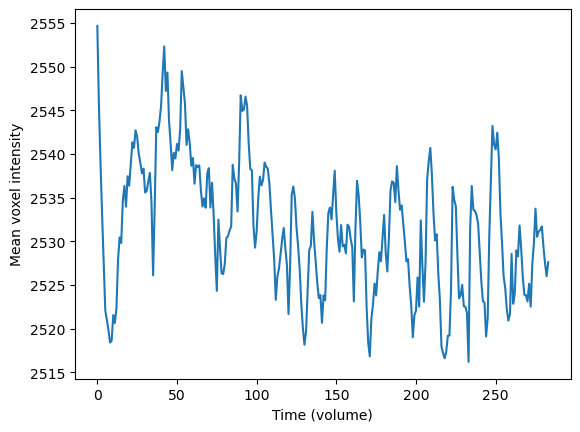

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(LR_Motor).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

# RL Motor run looks really similar with only the first volume having a slightly higher intensity

We considered that it was probably not a problem that the first volume had an intensity a little too big because we'll remove later. 

In [ ]:
# Visualize the result in FSLeyes before motion correction
fsleyesDisplay = FSLeyesServer() 
fsleyesDisplay.show() 
fsleyesDisplay.resetOverlays() 
fsleyesDisplay.load(out_path)

In [ ]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

In [5]:
from fsl.wrappers import mcflirt
import matplotlib.pyplot as plt

def run_mcflirt(moco_path, out_path, ref_vol = None):
    if ref_vol is None:
        # --- Compute the mean image across time ---
        print("Computing mean image as reference volume...")
        img = nib.load(out_path)
        data = img.get_fdata()
        mean_data = np.mean(data, axis=3)
        
        mean_img = nib.Nifti1Image(mean_data, img.affine, img.header)
        mean_ref_path = os.path.join(moco_path, "mean_ref.nii.gz")
        nib.save(mean_img, mean_ref_path)
        
        # Run MCFLIRT using mean as reference ---
        mcflirt(infile=out_path,o=moco_path+'/moco', plots=True, report=True, dof=6, mats=True, reffile = mean_ref_path)
    else:
        # Otherwise take the middle run of run 1 as reference
        mcflirt(infile=out_path,o=moco_path+'/moco', plots=True, report=True, dof=6, mats=True, refvol=ref_vol)

    def load_mot_params_fsl_6_dof(path):
        return pd.read_csv(path, sep='  ', header=None, 
                engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

    mot_params = load_mot_params_fsl_6_dof(moco_path + '/moco.par')
    fd = compute_FD_power(mot_params).to_numpy()

    threshold = 2 * np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
    
    plt.plot(list(range(1, fd.size+1)), fd)
    plt.xlabel('Volume')
    plt.ylabel('FD displacement (mm)')
    plt.hlines(threshold, 0, 580,colors='black', linestyles='dashed', label='FD threshold')
    plt.legend()
    plt.show()

    most_corrected_indices = (np.where(fd > threshold)[0]).tolist()
    print(f"Indices of frames above threshold: {most_corrected_indices}")
    return mot_params, most_corrected_indices

Processed data will be saved as /home/jovyan/Data/group_project/moco_mot_corr/moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [142] to 8 mm pixels
Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289]

refnum = 142
Original_refvol = 142


Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][

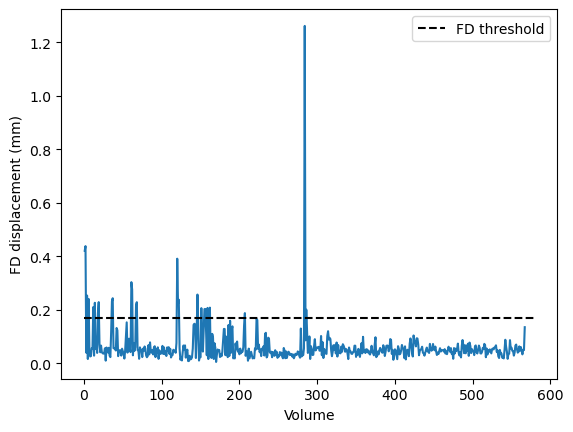

Indices of frames above threshold: [0, 1, 3, 5, 11, 13, 17, 18, 35, 36, 60, 61, 66, 67, 119, 120, 121, 145, 150, 154, 155, 158, 161, 206, 283, 285]


In [46]:
moco_path = save_path+"/moco_mot_corr"
mkdir_no_exist(moco_path)
mot_params_middle, most_corrected_indices_middle = run_mcflirt(moco_path, out_path, 142)

Computing mean image as reference volume...


Processed data will be saved as /home/jovyan/Data/group_project/moco_mot_corr_mean/moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [-1] to 8 mm pixels
Registering volumes ... [0][1][2][3][4][5][6][7][8][9][10][11][12][13][14][15][16][17][18][19][20][21][22][23][24][25][26][27][28][29][30][31][32][33][34][35][36][37][38][39][40][41][42][43][44][45][46][47][48][49][50][51][52][53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][

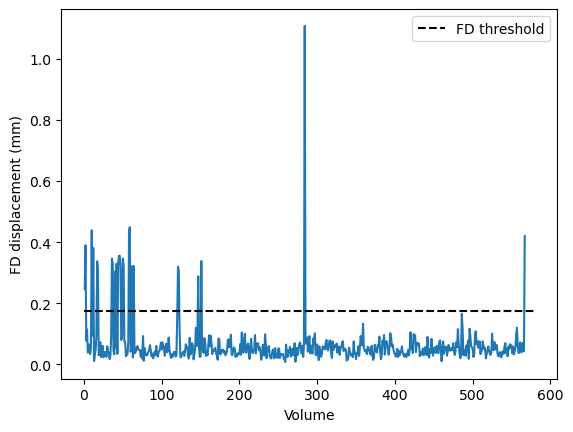

Indices of frames above threshold: [0, 1, 9, 11, 16, 17, 35, 36, 39, 41, 43, 44, 45, 46, 49, 50, 57, 58, 61, 63, 120, 121, 146, 150, 283, 566]


In [6]:
import gc
gc.collect()
moco_path = save_path+"/moco_mot_corr_mean"
mkdir_no_exist(moco_path)
mot_params, most_corrected_indices = run_mcflirt(moco_path, out_path)

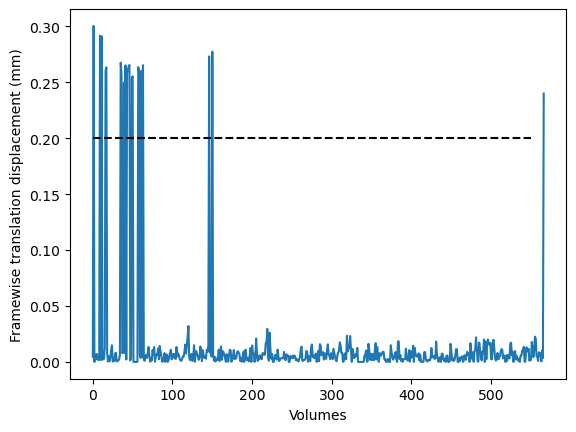

Indices of frames above threshold: [1, 9, 11, 16, 17, 35, 36, 39, 41, 43, 44, 45, 46, 49, 50, 57, 58, 61, 63, 146, 150, 566]


In [ ]:
# Getting the translation is easy
trans_y = mot_params["Translation y"]
# Now, we want a 0.2mm with respect to previous frame:
disp_y = np.diff(trans_y)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_y))
plt.hlines(threshold, 0, 550,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()
most_corrected_indices_trans_y = (np.where(np.abs(disp_y) > threshold)[0]).tolist()
print(f"Indices of frames above threshold: {most_corrected_indices_trans_y}")

We see here that the volumes having a Translation y bigger than the 0.2 mm threshold are a subset of those having an above-treshold frame-wise displacement. 

In [ ]:
# Compare the before and after motion correction
fsleyesDisplay = FSLeyesServer() 
fsleyesDisplay.show() 
fsleyesDisplay.resetOverlays() 
fsleyesDisplay.load(moco_path+"/moco.nii.gz")
fsleyesDisplay.load(out_path)

In [4]:
img = nib.load(moco_path+ "/moco.nii.gz")
voxel_sizes = img.header.get_zooms()
print("Voxel sizes (mm):", voxel_sizes[:3]) 

Voxel sizes (mm): (2.0, 2.0, 2.0)


In [ ]:
import subprocess

sigma = 4 / 2.3548 #FWHM = 4mm = 2*2mm
img_path = moco_path+ "/moco.nii.gz"
smoothed_path = img_path.replace('.nii', '_smoothed-4mm.nii')
subprocess.run(['fslmaths', img_path, '-s', str(sigma), smoothed_path])

import ok!


CompletedProcess(args=['fslmaths', '/home/jovyan/Data/group_project/moco_mot_corr_mean/moco.nii.gz', '-s', '1.6986580601324954', '/home/jovyan/Data/group_project/moco_mot_corr_mean/moco_smoothed-4mm.nii.gz'], returncode=0)

In [ ]:
# Visualize the smoothed result
fsleyesDisplay = FSLeyesServer() 
fsleyesDisplay.show() 
fsleyesDisplay.resetOverlays() 
fsleyesDisplay.load(smoothed_path)


(ipykernel_launcher.py:3310): Gdk-WARNING **: 11:20:02.459: gdkdrawable-x11.c:952 drawable is not a pixmap or window

(ipykernel_launcher.py:3310): Gdk-WARNING **: 11:20:20.817: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [14]:
# Coregistration (*Bonus - results not to be used for further steps)

# path to motion-corrected fMRI
epi_source = moco_path + "/moco.nii.gz"
coreg_path = 'home/joyvan/Data/group_project/coreg'
mkdir_no_exist(coreg_path)

# extract single volume from middle of fMRI sequency
ref_vol_name = moco_path + '/moco_vol_middle'
mid_vol_index = 568 // 2 #length of sequence = 562
fslroi(epi_source, ref_vol_name, str(mid_vol_index), str(1))

# T1 and preprocessed-T1 locations
whole_t1 = bids_root + '/subject101410/T1w/T1w.nii.gz'
skull_stripped_t1 = bids_root + '/subject101410/T1w/T1w_brain.nii.gz'
white_matter_segmentation = bids_root + '/subject101410/T1w/T1w_fast_pve_2.nii.gz' # We provide the white matter segmentation

# coregistration on middle volume
output_path = coreg_path + '/moco_vol_bbr'
subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])

FLIRT pre-alignment
Running BBR
0.951079 0.999878 0.014118 -0.006677 0.000000 -0.014216 0.999788 -0.014859 0.000000 0.006465 0.014952 0.999867 0.000000 1.719137 2.432122 5.342230 1.000000 


CompletedProcess(args=['epi_reg', '--epi=/home/jovyan/Data/group_project/moco_mot_corr/moco_vol_middle', '--t1=/data/data/subject101410/T1w/T1w.nii.gz', '--t1brain=/data/data/subject101410/T1w/T1w_brain.nii.gz', '--out=home/joyvan/Data/group_project/coreg/moco_vol_bbr', '--wmseg=/data/data/subject101410/T1w/T1w_fast_pve_2.nii.gz'], returncode=0)

In [ ]:
# Visualise if the coregistration worked
fsleyesDisplay = FSLeyesServer() 
fsleyesDisplay.show()
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1) #source
fsleyesDisplay.load(output_path) #target

Comment on coregistration: The orientation of the EPI and T1 volume are similar about the centre as seen on the overlay,
indicating a good alignment overall. However, there are slight mismatches at the outer edges,
likely due to the small differences in the original T1 and brain-mask used to extract skull-stripped volume.
We have used white matter masks generated by our segmentation process, 
so any pre-existing noise in the segmentation mask would have been carried over.